In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; # proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0> rho;
    
    
    // autoregressive coefficients
    vector[I]                  xis;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    # for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    xis    ~ uniform(0,1); //switch between beta in (-1,1) to uniform(0,1)
    vs     ~ beta(1,alpha);

    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) 
    {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h] + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T));
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    for (i in 1:I) 
    {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h] + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T));
        
        s[i] = categorical_rng(softmax(log_probs));
    }
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

10:14:02 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/bayesian.stan to exe file /home/riccardo/bayesian-project/bayesian
10:14:40 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/bayesian


[[1. 0. 1. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]


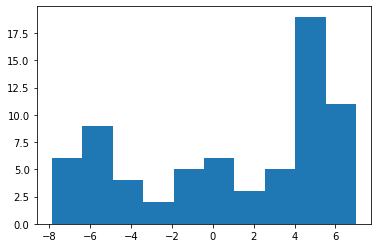

In [20]:
I = 10
T = 7
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
     
Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1
}


In [17]:
true_clus_allocs

array([2., 0., 1., 0., 1., 1., 1., 1., 2., 0.])

In [14]:
fit = dp_mix.sample(data, show_console = True)

10:26:25 - cmdstanpy - INFO - Chain [1] start processing
10:26:25 - cmdstanpy - INFO - Chain [2] start processing
10:26:25 - cmdstanpy - INFO - Chain [3] start processing
10:26:25 - cmdstanpy - INFO - Chain [4] start processing
10:26:25 - cmdstanpy - INFO - Chain [2] done processing
10:26:25 - cmdstanpy - INFO - Chain [1] done processing
10:26:25 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
10:26:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:26:25 - cmdstanpy - INFO - Chain [4] done processing
10:26:25 - cmdstanpy - INFO - Chain [3] done processing
10:26:25 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
10:26:25 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted


Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 1000 (Default)
Chain [2] num_warmup = 1000 (Default)
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (Default)
Chain [2] stepsize = 1 (Default)
Chain [1] method = sample (Default)
Chain [4] method = sample (Default)
Chain [4] sample
Chain [4] num_samples = 1000 (Default)
Chain [4] num_warmup = 1000 (Default)
Chain [4] save_warmup = 0 (Default)
Chain [4] thin = 1 (Default)
Chain [4] adapt
Chain [2

RuntimeError: Error during sampling:
Exception: beta_lpdf: Random variable is 1.48712, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.87338, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.38421, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.37891, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.08564, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.8844, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.83277, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.28141, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.97164, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.53502, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.18407, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.24616, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.76654, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.69591, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.97236, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.27793, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.03718, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.27696, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.00984, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.44949, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.72229, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.20579, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.3647, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.01372, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.50944, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.3058, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.45985, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.64837, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.15616, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.46556, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.07064, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.97332, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.79651, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.74504, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.52371, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.79673, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.30026, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.9286, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.66102, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.92821, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.57886, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.99372, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.24487, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.19212, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.83145, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.70268, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.36705, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.08749, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.24103, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 2.33491, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.77732, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.79094, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.60628, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.13548, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.64195, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.38847, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.66177, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.5243, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.61278, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.2194, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.76527, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.50719, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.0343, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.03199, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.24454, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.09958, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.04914, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.07056, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.09283, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.44252, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.65996, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.28213, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.34385, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.03803, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.51721, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.925, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.57379, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.64991, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.77598, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.02772, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.95978, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.36856, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.69723, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.75934, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.77643, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.09386, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.88844, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.60694, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.12232, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.46816, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.42609, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.73141, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.12317, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.83724, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.47542, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.60792, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.39964, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.03825, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.68674, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.07818, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.94585, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 1.08246, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.90169, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.68433, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.54318, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.65038, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.99116, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.10447, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.23834, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.4093, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.75437, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.418, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.66892, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.06202, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.73892, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.59775, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.15991, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.4447, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.70448, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.25686, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.85926, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.01572, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.65636, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.09957, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.04553, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.51599, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.91594, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.03139, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.34605, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.86684, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.46191, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.13509, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.15958, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.26631, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.15596, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.71096, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.75236, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.86365, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.5078, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.77417, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.45882, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.33517, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.84576, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.91999, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.08376, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.78747, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.04717, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.77194, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.54915, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.58824, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 3.1967, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.88468, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.56698, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.02543, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.09663, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.22757, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.92167, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.78926, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.30393, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.4685, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.24131, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.03671, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.44067, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.89985, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.46985, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.8602, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.99702, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.70219, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.58744, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.34271, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.36653, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.96557, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.72579, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.05482, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.93385, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.81642, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.32349, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.952, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.91034, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.71508, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.17066, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.96663, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.88622, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.15739, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.78848, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.58894, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.28085, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/riccardo/bayesian-project/bayesian', 'id=1', 'random', 'seed=31534', 'data', 'file=/tmp/tmp997xn3yu/nq1o02ni.json', 'output', 'file=/tmp/tmp997xn3yu/bayesianjr0_t3hl/bayesian-20221216102625_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp997xn3yu/bayesianjr0_t3hl/bayesian-20221216102625_1.csv
 console_msgs (if any):
	/tmp/tmp997xn3yu/bayesianjr0_t3hl/bayesian-20221216102625_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!